1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

3. [опция]. Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def calc_mse(y_pred, y):
    return np.mean((y - y_pred) ** 2)

In [3]:
def gdmodel(data: np.array, target: np.array, alfa: float, iterations: list, qty_in_batch=None, stoch=False, l1=False, l2=False, lamda=1e-5) -> dict:
    weights = np.zeros(data.shape[1])
    mse = calc_mse(np.dot(data, weights), target)
    result = {}
    for n_iter in iterations:
        if not stoch:
            for i in range(n_iter):
                weights -= alfa * 2 * np.dot((np.dot(data, weights) - target), data) / data.shape[0]
                mse = calc_mse(np.dot(data, weights), target)
            result[f'mse {n_iter} iters'] = mse
            
        else:
            n = data.shape[1]
            if qty_in_batch == None:
                qty_in_batch = n
            n_batch = np.math.ceil(n / qty_in_batch)
            train_ind = np.random.randint(data.shape[0])
            for i in range(n_iter):
                y_pred = np.dot(data, weights)
                mse = calc_mse(y_pred, target)
                for ii in range(n_batch):
                    batch_start = ii * qty_in_batch
                    batch_end = (ii + 1) * qty_in_batch
                    data_tmp = data[batch_start:batch_end, :]
                    target_tmp = target[batch_start:batch_end]
                    if l1:
                        weights -= alfa * 2 * np.dot((np.dot(data_tmp, weights) - target_tmp), data_tmp) / n + lamda * np.linalg.norm(weights, ord=1)
                    elif l2:
                        weights -= alfa * 2 * np.dot((np.dot(data_tmp, weights) - target_tmp), data_tmp) / n + lamda * np.linalg.norm(weights, ord=2)
                    else:
                        weights -= alfa * 2 * np.dot((np.dot(data_tmp, weights) - target_tmp), data_tmp) / n
            result[f'mse {n_iter} iters'] = mse
    return result

In [4]:
data, target, coef = make_regression(n_samples=10000, n_features = 5, n_informative = 2, n_targets = 1, 
                                              noise = 5, coef = True, random_state = 2)
iterations = [10 ** i for i in range(1, 7)]
result_regular_gd, result_stochastic_gd = gdmodel(data, target, 0.001, iterations), gdmodel(data, target, 0.001, iterations, stoch=True)
compare = pd.concat([pd.DataFrame(result_regular_gd, index=[0]),
                     pd.DataFrame(result_stochastic_gd, index=[0])],
                    ignore_index=True)
compare.index = ['REG', 'STOCH']
compare

,mse 10 iters,mse 100 iters,mse 1000 iters,mse 10000 iters,mse 100000 iters,mse 1000000 iters
REG,14385.085422,9637.464064,199.017226,24.943066,24.943066,24.943066
STOCH,14710.591388,12678.847953,10194.318365,8451.498113,1544.736969,117.401148


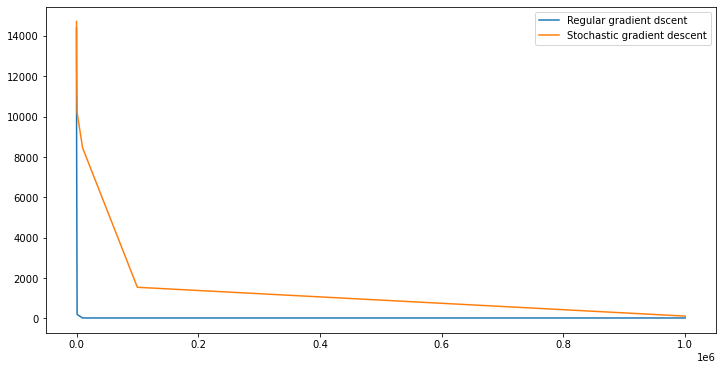

In [5]:
plt.figure(figsize = (12, 6))
plt.plot(iterations, result_regular_gd.values(), label='Regular gradient dscent')
plt.plot(iterations, result_stochastic_gd.values(), label='Stochastic gradient descent')
plt.legend()
plt.show()

Из графика видно, что в нашем случае обычный градиентный спуск работает лучше, тк быстрее получит минимальные значения ошибки, но при определенном количестве итераций результат будет схож у обеих моделей.

In [6]:
stoch_l1, stoch_l2 = gdmodel(data, target, 0.001, iterations, stoch=True, l1=True), gdmodel(data, target, 0.001, iterations, stoch=True, l2=True)
compare_stoch_l1_l2 = pd.concat([pd.DataFrame(result_regular_gd, index=[0]),
                                 pd.DataFrame(result_stochastic_gd, index=[0]),
                                 pd.DataFrame(stoch_l1, index=[0]),
                                 pd.DataFrame(stoch_l2, index=[0])],
                                ignore_index=True)
compare_stoch_l1_l2.index = ['REG', 'STOCH', 'L1', 'L2']
compare_stoch_l1_l2

,mse 10 iters,mse 100 iters,mse 1000 iters,mse 10000 iters,mse 100000 iters,mse 1000000 iters
REG,14385.085422,9637.464064,199.017226,24.943066,24.943066,24.943066
STOCH,14710.591388,12678.847953,10194.318365,8451.498113,1544.736969,117.401148
L1,14710.634874,12684.091253,10334.625151,10182.562589,9710.460915,9578.083927
L2,14710.618843,12682.179615,10283.072633,9453.073869,5639.323115,4481.293424


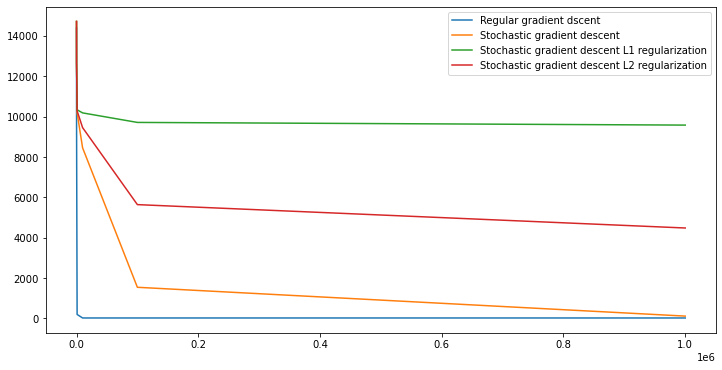

In [7]:
plt.figure(figsize = (12, 6))
plt.plot(iterations, result_regular_gd.values(), label='Regular gradient dscent')
plt.plot(iterations, result_stochastic_gd.values(), label='Stochastic gradient descent')
plt.plot(iterations, stoch_l1.values(), label='Stochastic gradient descent L1 regularization')
plt.plot(iterations, stoch_l2.values(), label='Stochastic gradient descent L2 regularization')
plt.legend()
plt.show()

Уже из датафрейма бфло видно, что регуляризации не поспособствовали улучшению результата, но с графиком красивее.<br>Лучше всех справилась с задачей обычная модель градиентного спуска.<br>Попробуем уменьшить лямбду...

In [15]:
stoch_l1, stoch_l2 = gdmodel(data, target, 0.001, iterations, stoch=True, l1=True, lamda=1e-10) , gdmodel(data, target, 0.001, iterations, stoch=True, l2=True, lamda=1e-10)
compare_stoch_l1_l2 = pd.concat([pd.DataFrame(result_regular_gd, index=[0]),
                                 pd.DataFrame(result_stochastic_gd, index=[0]),
                                 pd.DataFrame(stoch_l1, index=[0]),
                                 pd.DataFrame(stoch_l2, index=[0])],
                                ignore_index=True)
compare_stoch_l1_l2.index = ['REG', 'STOCH', 'L1', 'L2']
compare_stoch_l1_l2

,mse 10 iters,mse 100 iters,mse 1000 iters,mse 10000 iters,mse 100000 iters,mse 1000000 iters
REG,14385.085422,9637.464064,199.017226,24.943066,24.943066,24.943066
STOCH,14710.591388,12678.847953,10194.318365,8451.498113,1544.736969,117.401148
L1,14710.591389,12678.848006,10194.319761,8451.515041,1544.793504,117.423481
L2,14710.591389,12678.847987,10194.319251,8451.507918,1544.769702,117.416266


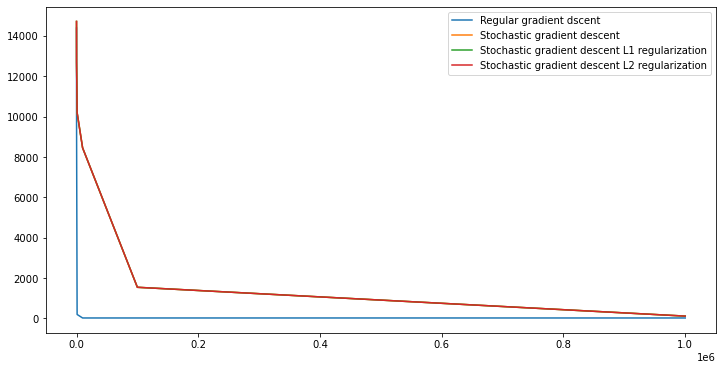

In [16]:
plt.figure(figsize = (12, 6))
plt.plot(iterations, result_regular_gd.values(), label='Regular gradient dscent')
plt.plot(iterations, result_stochastic_gd.values(), label='Stochastic gradient descent')
plt.plot(iterations, stoch_l1.values(), label='Stochastic gradient descent L1 regularization')
plt.plot(iterations, stoch_l2.values(), label='Stochastic gradient descent L2 regularization')
plt.legend()
plt.show()